In [21]:
# ! pip install optuna optuna-integration[xgboost]

In [22]:
# !pip list | grep optuna

In [23]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [24]:
import pandas as pd
import numpy as np
import optuna
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import joblib
import torch

# Set random seed for reproducibility
np.random.seed(42)

# Load the data
path_train = "./data/project_train.csv"
df = pd.read_csv(path_train, index_col=0)

# Set preprocessing threshold
preprocessing_threshold = 0.0

# Separate features and target
X = df.drop("TARGET", axis=1)
y = (df["TARGET"] > preprocessing_threshold).astype(int)

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
train_valid_splits = list(tscv.split(X))

gpu_available = torch.cuda.is_available()
print(f"GPU Available: {gpu_available}")


def threshold_sum(y_true: np.ndarray, y_pred: np.ndarray, threshold: float) -> float:
    """
    Calculate the sum of original targets for which the model predictions are above the threshold.

    Args:
        y_true (np.ndarray): The true target values (original float values).
        y_pred (np.ndarray): The predicted probabilities for the positive class.
        threshold (float): The threshold value to filter predictions.

    Returns:
        float: The sum of original target values where predictions exceed the threshold.
    """
    adjusted_target = np.where(y_pred > threshold, df["TARGET"].iloc[y_true.index], 0)
    return np.sum(adjusted_target)


def objective(trial: optuna.Trial) -> float:
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-4, 1.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-4, 1.0, log=True),
        "early_stopping_rounds": 10,
        "objective": "binary:logistic",
        "eval_metric": "logloss",
    }

    custom_metric_threshold = 0.5

    if gpu_available:
        params["device"] = "cuda"
        params["tree_method"] = "gpu_hist"

    log_loss_scores = []
    auc_scores = []
    custom_metric_values = []

    for train_index, valid_index in train_valid_splits:
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

        model = xgb.XGBClassifier(**params)
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)

        y_pred_proba = model.predict_proba(X_valid)[:, 1]

        # Calculate log loss (our primary metric)
        ll_score = log_loss(y_valid, y_pred_proba)
        log_loss_scores.append(ll_score)

        # Calculate AUC (for logging purposes)
        auc_score = roc_auc_score(y_valid, y_pred_proba)
        auc_scores.append(auc_score)

        # Calculate custom metric (for logging purposes)
        custom_metric_value = threshold_sum(y_valid, y_pred_proba, custom_metric_threshold)
        custom_metric_values.append(custom_metric_value)

    mean_log_loss = np.mean(log_loss_scores)
    mean_auc = np.mean(auc_scores)
    total_custom_metric_value = sum(custom_metric_values)

    # Log additional metrics
    trial.set_user_attr("mean_auc", mean_auc)
    trial.set_user_attr("sum_custom_metric", total_custom_metric_value)

    return mean_log_loss


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=200, n_jobs=1 if gpu_available else -1)

print("Best trial:")
trial = study.best_trial
print("  Log Loss: ", trial.value)
print("  AUC: ", trial.user_attrs["mean_auc"])
print("  Custom Metric: ", trial.user_attrs["sum_custom_metric"])
params = trial.params
print("  Params: ")
for key, value in params.items():
    print("    {}: {}".format(key, value))

joblib.dump(study, "./studies/xgboost_classifier_optuna_study.pkl")

best_params = trial.params
if gpu_available:
    best_params["device"] = "cuda"
    best_params["tree_method"] = "gpu_hist"

final_model = xgb.XGBClassifier(**best_params)
final_model.fit(X, y)

final_model.save_model("./models/xgboost_classifier.json")

print("Optimization complete. Study and best model saved.")

[I 2024-10-20 14:03:58,283] A new study created in memory with name: no-name-e12d8c22-7baa-4823-a77e-789458e5707e


GPU Available: False


[I 2024-10-20 14:04:35,173] Trial 0 finished with value: 0.6916025162413839 and parameters: {'n_estimators': 129, 'max_depth': 8, 'learning_rate': 0.023505982639470464, 'min_child_weight': 5, 'subsample': 0.9227248646820867, 'colsample_bytree': 0.7479868644189855, 'gamma': 0.8971428054070562, 'reg_alpha': 0.0014576887444798547, 'reg_lambda': 0.0025395163002155346}. Best is trial 0 with value: 0.6916025162413839.
[I 2024-10-20 14:04:50,091] Trial 1 finished with value: 0.6912720699649814 and parameters: {'n_estimators': 337, 'max_depth': 7, 'learning_rate': 0.015390001237034533, 'min_child_weight': 9, 'subsample': 0.9348764137236878, 'colsample_bytree': 0.9528890461319891, 'gamma': 0.4082247505223252, 'reg_alpha': 0.007789378787624766, 'reg_lambda': 0.0009877479888574315}. Best is trial 1 with value: 0.6912720699649814.
[I 2024-10-20 14:05:09,175] Trial 2 finished with value: 0.6920505159935847 and parameters: {'n_estimators': 426, 'max_depth': 9, 'learning_rate': 0.033327297586097614, 

Best trial:
  Log Loss:  0.6908238560909042
  AUC:  0.5392088454209791
  Custom Metric:  -13.788049959599984
  Params: 
    n_estimators: 481
    max_depth: 3
    learning_rate: 0.05464619850635134
    min_child_weight: 1
    subsample: 0.703019859788306
    colsample_bytree: 0.8147175561536126
    gamma: 0.8501594460190887
    reg_alpha: 0.9934145046932791
    reg_lambda: 0.7313712144602689
Optimization complete. Study and best model saved.


<ipython-input-25-40293ad1438b>:15: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


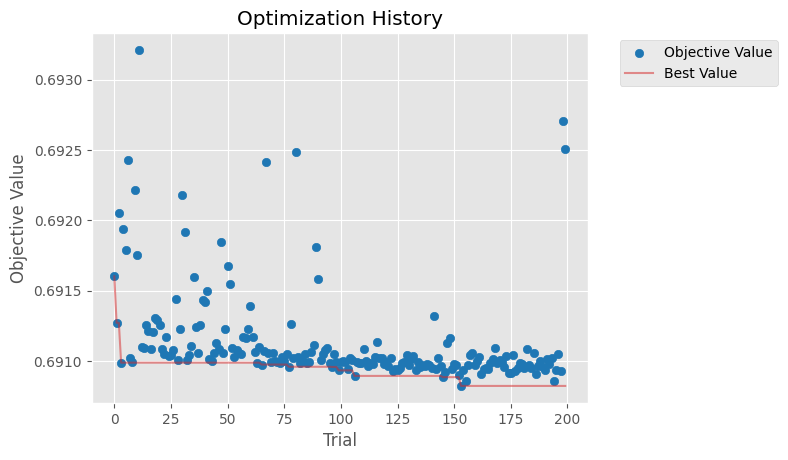

<ipython-input-25-40293ad1438b>:21: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


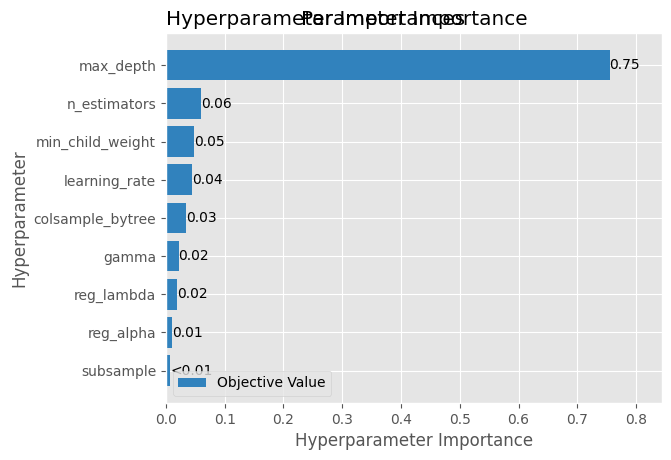

<ipython-input-25-40293ad1438b>:27: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(study)


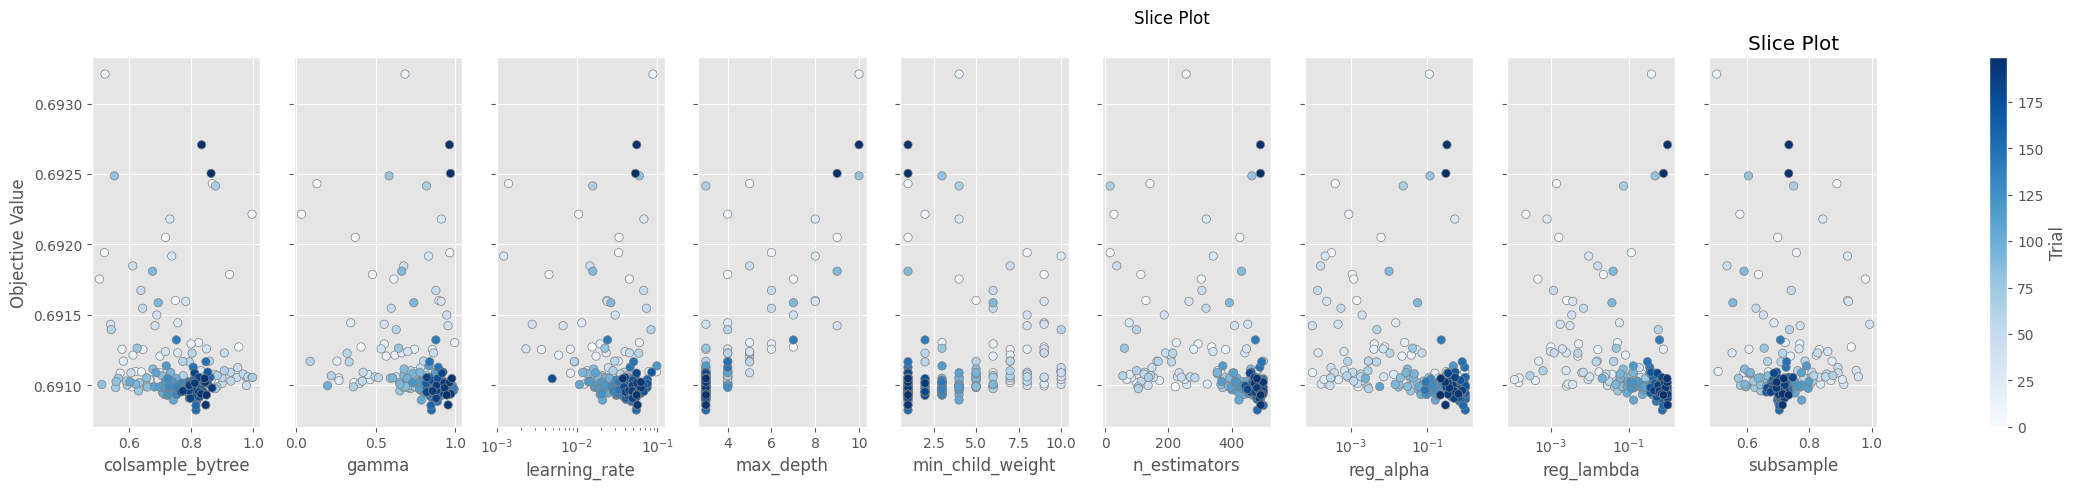

<ipython-input-25-40293ad1438b>:33: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_contour(study)
[W 2024-10-20 14:54:29,624] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


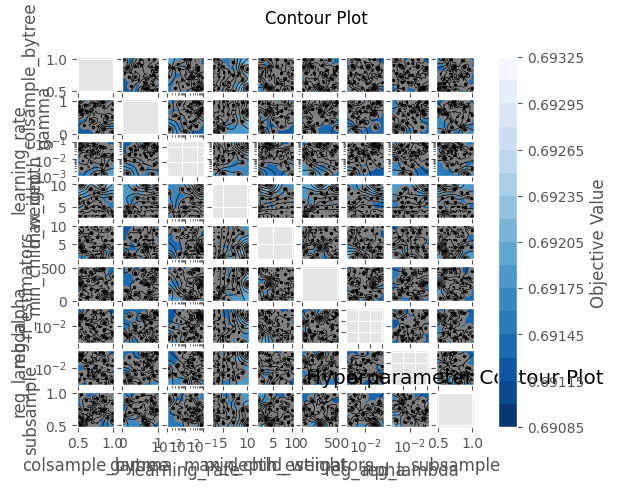

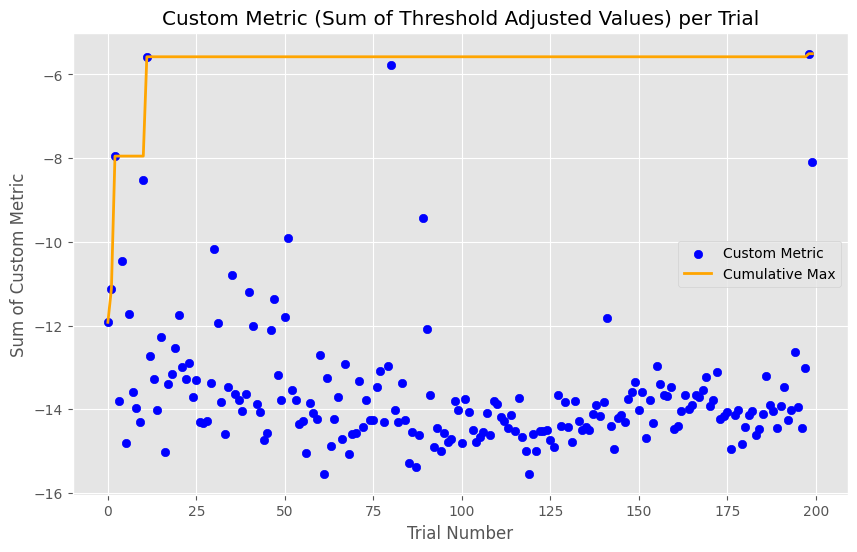

Accuracy: 0.5843
Precision: 0.5843152090163545
Recall: 0.5843
F1 Score: 0.5842658234069191
ROC-AUC: 0.6248089570391613


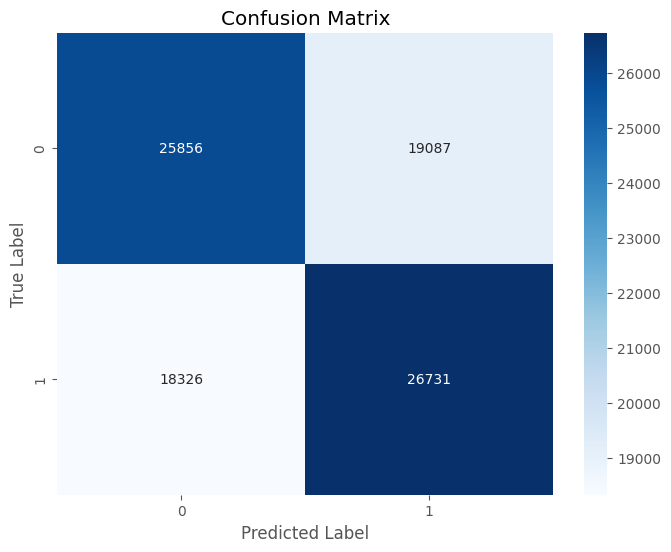

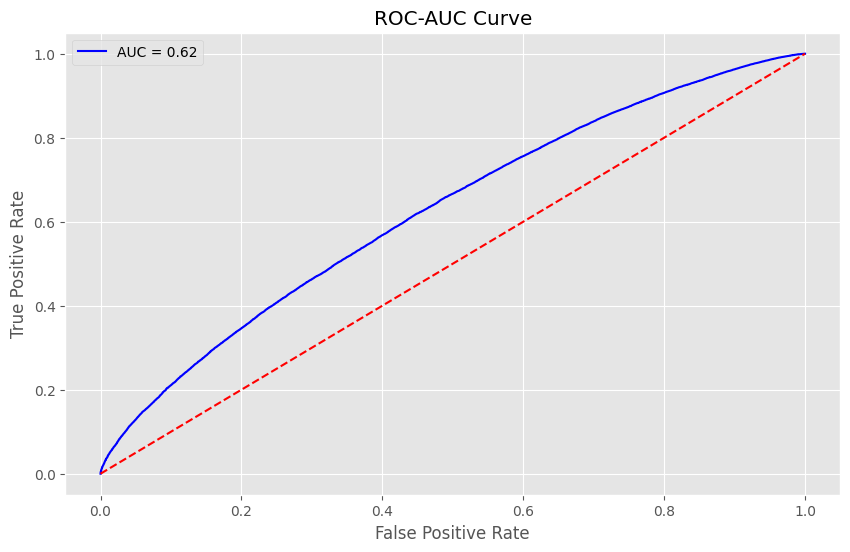


Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.58      0.58     44943
           1       0.58      0.59      0.59     45057

    accuracy                           0.58     90000
   macro avg       0.58      0.58      0.58     90000
weighted avg       0.58      0.58      0.58     90000



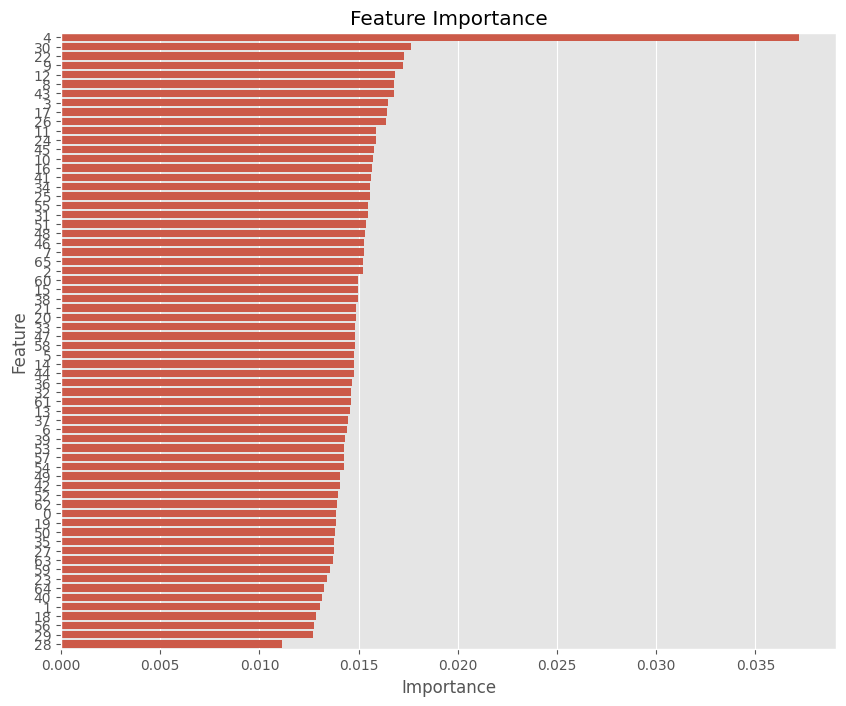


Best Trial Summary:

  Value: 0.6908238560909042
  Params:
    n_estimators: 481
    max_depth: 3
    learning_rate: 0.05464619850635134
    min_child_weight: 1
    subsample: 0.703019859788306
    colsample_bytree: 0.8147175561536126
    gamma: 0.8501594460190887
    reg_alpha: 0.9934145046932791
    reg_lambda: 0.7313712144602689


In [25]:
import pandas as pd
import numpy as np
import optuna
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)
import joblib
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import optuna.visualization as vis

# Plot the optimization history
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.title("Optimization History")
plt.savefig("./plots/optimization_history.png")
plt.show()

# Plot parameter importance
optuna.visualization.matplotlib.plot_param_importances(study)
plt.title("Parameter Importance")
plt.savefig("./plots/param_importance.png")
plt.show()

# Plot slice plot for detailed analysis
optuna.visualization.matplotlib.plot_slice(study)
plt.title("Slice Plot")
plt.savefig("./plots/slice_plot.png")
plt.show()

# Plot contour plot for interactions between parameters
optuna.visualization.matplotlib.plot_contour(study)
plt.title("Hyperparameter Contour Plot")
plt.savefig("./plots/contour_plot.png")
plt.show()

# Extract custom metric values from the study (if applicable)
custom_metric_values = []
for trial in study.trials:
    custom_metric_values.append(trial.user_attrs["sum_custom_metric"])

cumulative_max = np.maximum.accumulate(custom_metric_values)

# Create the scatter plot and the line for the cumulative max
plt.figure(figsize=(10, 6))
plt.scatter(range(len(custom_metric_values)), custom_metric_values, label="Custom Metric", color="blue")
plt.plot(cumulative_max, label="Cumulative Max", color="orange", linewidth=2)

plt.title("Custom Metric (Sum of Threshold Adjusted Values) per Trial")
plt.xlabel("Trial Number")
plt.ylabel("Sum of Custom Metric")
plt.grid(True)
plt.legend()
plt.show()

# Predictions from the final model
y_pred = final_model.predict(X)
y_pred_prob = final_model.predict_proba(X)[:, 1]  # Assuming binary classification for ROC-AUC

# Calculate classification evaluation metrics
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred, average="weighted")
recall = recall_score(y, y_pred, average="weighted")
f1 = f1_score(y, y_pred, average="weighted")
roc_auc = roc_auc_score(y, y_pred_prob)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC-AUC: {roc_auc}")

# Plot confusion matrix
conf_matrix = confusion_matrix(y, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig("./plots/confusion_matrix.png")
plt.show()

# Plot ROC-AUC curve
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y, y_pred_prob)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color="blue", label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.title("ROC-AUC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.savefig("./plots/roc_auc_curve.png")
plt.show()

# Plot classification report as a text block
report = classification_report(y, y_pred)
print("\nClassification Report:")
print(report)

# Save classification report to a text file
with open("./plots/classification_report.txt", "w") as f:
    f.write(report)

# Get feature importance
importance = final_model.feature_importances_
features = X.columns

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({"Feature": features, "Importance": importance}).sort_values(
    by="Importance", ascending=False
)

# Plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df)
plt.title("Feature Importance")
plt.savefig("./plots/feature_importance.png")
plt.show()

# Best trial information
best_trial = study.best_trial

print(f"\nBest Trial Summary:\n")
print(f"  Value: {best_trial.value}")
print(f"  Params:")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

with open("./studies/best_trial_summary.txt", "w") as f:
    f.write(f"Best Trial Value: {best_trial.value}\n")
    f.write(f"Best Parameters:\n")
    for key, value in best_trial.params.items():
        f.write(f"  {key}: {value}\n")

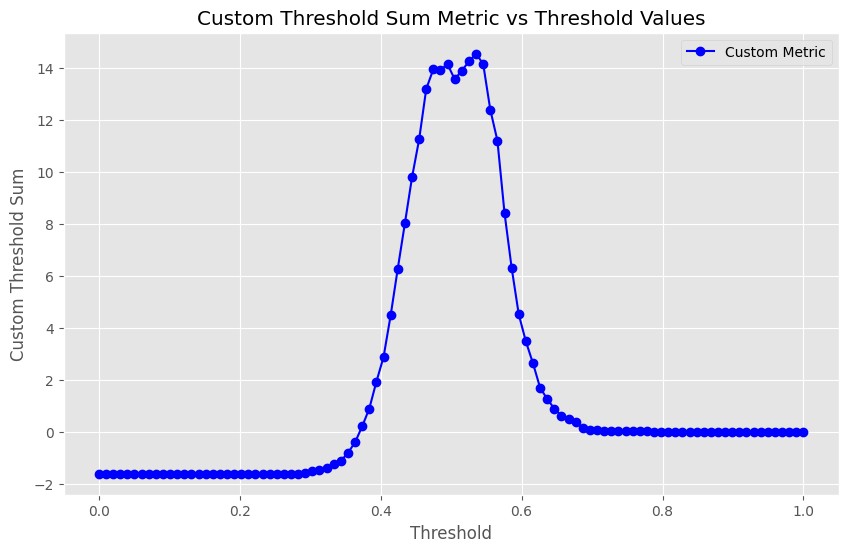

In [26]:
# Assuming binary classification, predict the probabilities of the positive class (class 1)
y_pred_prob = final_model.predict_proba(X)[:, 1]

# Define threshold values between 0 and 1 (since probabilities are between 0 and 1)
threshold_values = np.linspace(0, 1, 100)  # 100 threshold values between 0 and 1

custom_metric_values = []

# Compute custom metric for each threshold value
for threshold in threshold_values:
    custom_metric_value = threshold_sum(y, y_pred_prob, threshold)
    custom_metric_values.append(custom_metric_value)

# Plot the custom metric vs threshold
plt.figure(figsize=(10, 6))
plt.plot(threshold_values, custom_metric_values, marker="o", color="b", label="Custom Metric")
plt.title("Custom Threshold Sum Metric vs Threshold Values")
plt.xlabel("Threshold")
plt.ylabel("Custom Threshold Sum")
plt.grid(True)
plt.legend()
plt.savefig("./plots/custom_metric_vs_threshold.png")
plt.show()

Custom Threshold Sum (Threshold = 0.5): 14.019170657100016


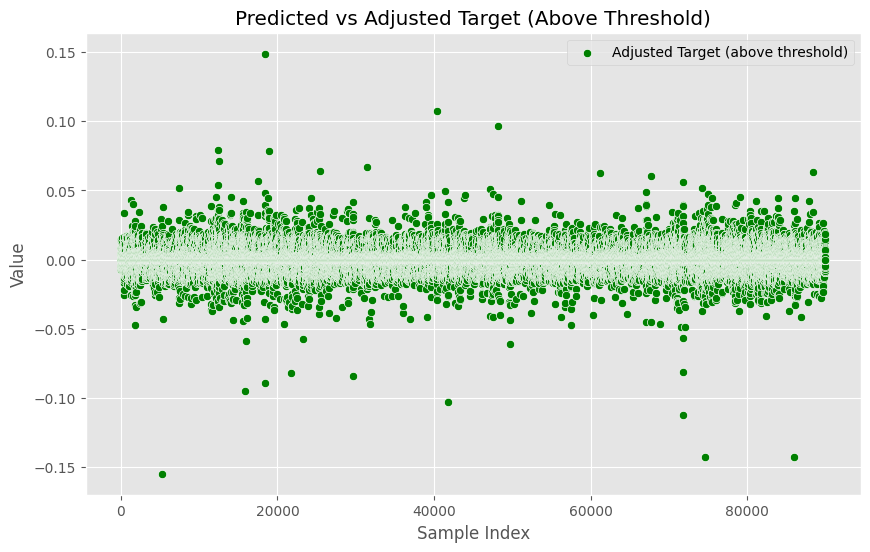

In [35]:
y_pred_prob = final_model.predict_proba(X)[:, 1]

threshold = 0.5

custom_metric_value = threshold_sum(y, y_pred, threshold)
print(f"Custom Threshold Sum (Threshold = {threshold}): {custom_metric_value}")

# Plot predicted vs adjusted target (above threshold)
adjusted_y = np.where(y_pred_prob > threshold, df["TARGET"], 0)

plt.figure(figsize=(10, 6))
# sns.scatterplot(x=range(len(y)), y=y_pred_prob, label='Predicted Probabilities', alpha=0.5)
sns.scatterplot(x=range(len(y)), y=adjusted_y, label="Adjusted Target (above threshold)", color="green")
# plt.axhline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
plt.title("Predicted vs Adjusted Target (Above Threshold)")
plt.xlabel("Sample Index")
plt.ylabel("Value")
plt.legend()
plt.savefig("./plots/predicted_vs_adjusted_threshold.png")
plt.show()